In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## Numerical columns

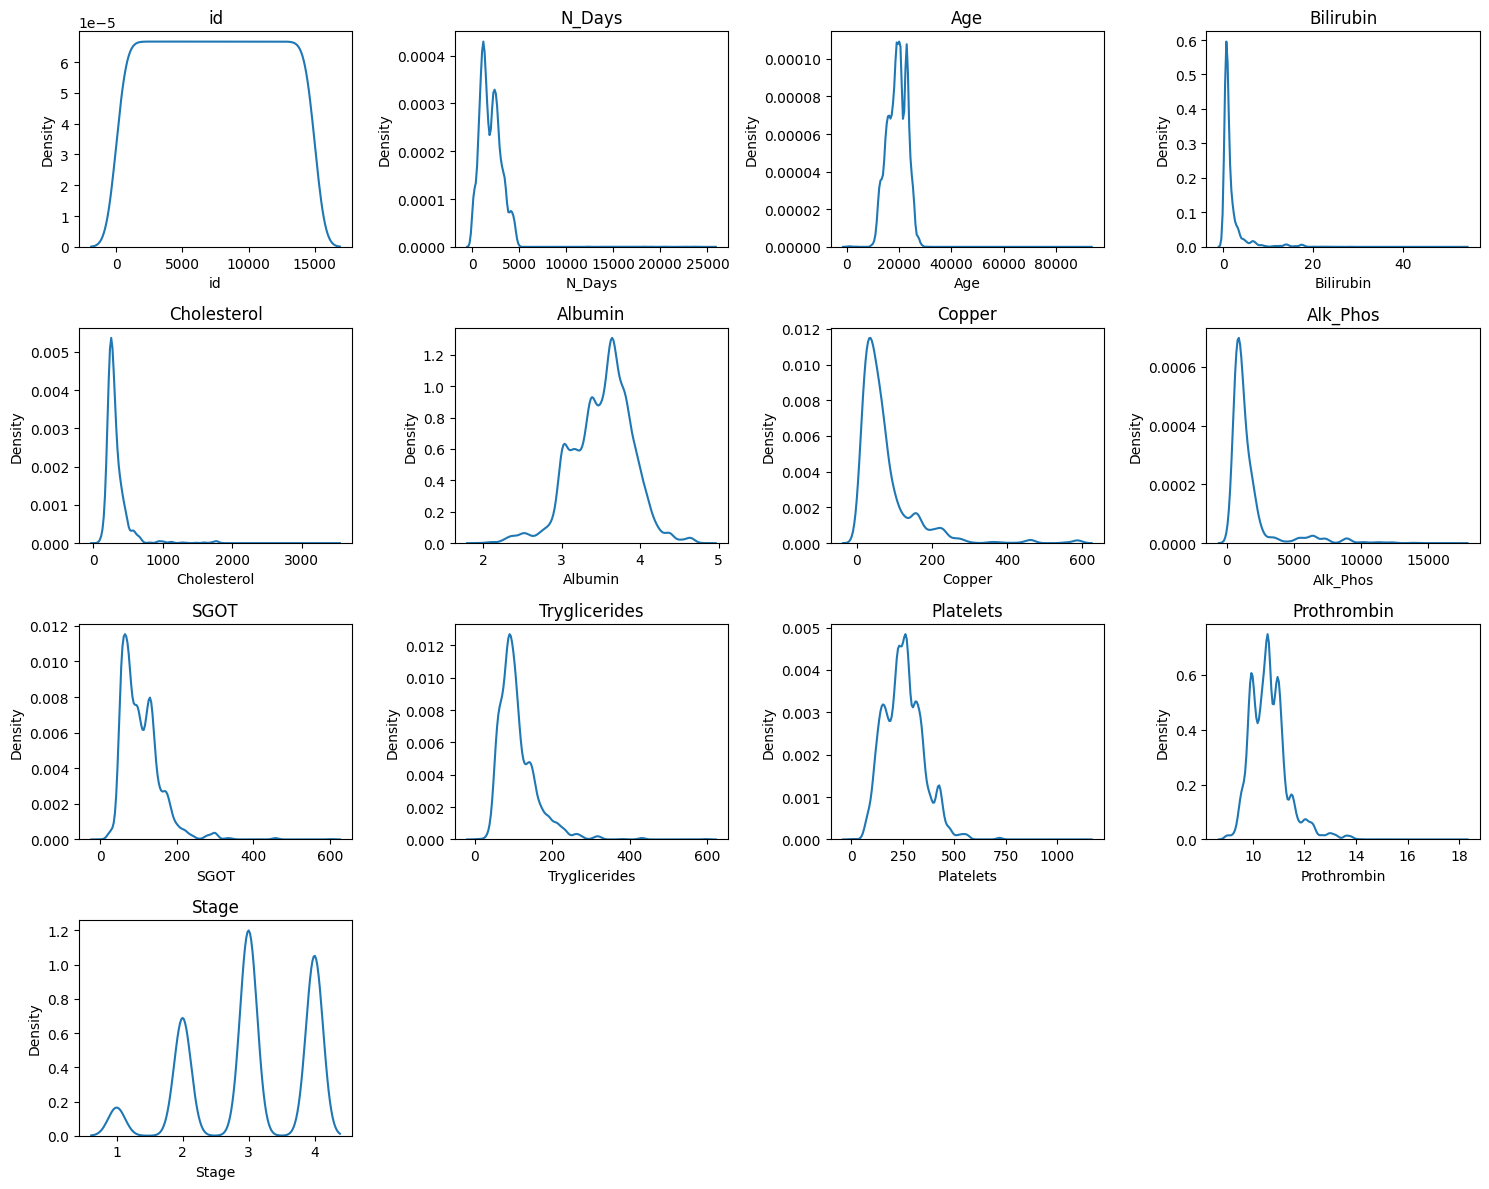

In [ ]:
num_cols = train.select_dtypes(exclude=['object']).columns

plt.figure(figsize=(15, 12))

for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)
    sns.kdeplot(x=col, data=train)
    plt.title(col)
    plt.tight_layout()


In [ ]:
for col in num_cols:
  if(train[col].isnull().sum()>1):
    print(col, train[col].isnull().sum())

Cholesterol 8377
Copper 6662
Alk_Phos 6550
SGOT 6554
Tryglicerides 8426
Platelets 538
Prothrombin 19


### Fix the null values using Random Sample Imputation

In [ ]:
import numpy as np

def random_sample_impute(df, col):
    missing = df[col].isnull()
    df.loc[missing, col] = np.random.choice(df[col].dropna(), size=missing.sum(), replace=True)
    return df

for col in num_cols:
    train = random_sample_impute(train, col)
    test = random_sample_impute(test, col)


### Fix Skewness

In [ ]:
from scipy.stats import  skew

skewness = train[num_cols].apply(lambda x: skew(x.dropna()))
skew_cols = skewness[skewness>0.75].index.tolist()

for col in skew_cols:
  train[col] = np.log1p(train[col])
  test[col] = np.log1p(test[col])

### Fix outliers

In [ ]:
out_cols = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

def cap_extreme_outliers(df, cols):
  for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr

    df[col] = np.clip(df[col], lower, upper)
  return df

train = cap_extreme_outliers(train, out_cols)
test = cap_extreme_outliers(test, out_cols)

## Categorical Columns

### Find null values

In [ ]:
cat_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# Null values
for col in cat_cols:
  if(train[col].isnull().sum()>1):
    print(col, train[col].isnull().sum())

Drug 6543
Ascites 6536
Hepatomegaly 6547
Spiders 6551


In [ ]:
# No of uniques for each cat_cols
for col in cat_cols:
  print(col, train[col].nunique())

Drug 2
Sex 2
Ascites 2
Hepatomegaly 2
Spiders 3
Edema 3


In [ ]:
def input_nan(df, variable):
  df[variable] = np.where(df[variable].isnull(), 'M', df[variable])
  return df

cat_null = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']
for col in cat_null:
  train = input_nan(train, col)
  test = input_nan(test, col)


In [ ]:
# Get the value counts for each cat_cols
for col in cat_cols:
  print(f"\nColumn: {train[col].value_counts()}")


Column: Drug
M                  6543
D-penicillamine    4501
Placebo            3956
Name: count, dtype: int64

Column: Sex
F    14373
M      627
Name: count, dtype: int64

Column: Ascites
N    8068
M    6536
Y     396
Name: count, dtype: int64

Column: Hepatomegaly
M    6547
N    4662
Y    3791
Name: count, dtype: int64

Column: Spiders
N         6717
M         6551
Y         1731
119.35       1
Name: count, dtype: int64

Column: Edema
N    13872
S      763
Y      365
Name: count, dtype: int64


In [ ]:
# Fix weird values
train['Spiders'] = train['Spiders'].replace({119.35: 'M'})
test['Spiders'] = test['Spiders'].replace({119.35: 'M'})

# Define categorical columns
cat_cols = ['Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# Label encoding
from sklearn.preprocessing import LabelEncoder

feature_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    feature_encoders[col] = le


In [ ]:
train.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')

In [ ]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,6.756932,2,17841.0,0,1,2,2,0,1.131402,5.983936,3.70,4.317488,7.672758,4.925368,4.976734,298.0,2.484907,4.0,D
1,1,7.040536,2,18102.0,0,1,2,3,1,1.131402,5.236442,3.48,1.609438,6.823286,4.803201,4.510860,213.0,2.595255,2.0,D
2,2,6.749931,0,16728.0,0,1,2,3,0,1.902108,6.180017,3.67,5.087596,9.354700,4.925368,5.111988,102.0,2.525729,4.0,D
3,3,7.487734,0,19358.0,0,1,2,2,0,1.131402,5.860786,3.36,4.317488,6.495266,5.612398,5.446737,166.0,2.517696,4.0,D
4,4,7.257708,2,22306.0,0,1,2,3,1,1.098612,6.056784,3.74,4.465908,9.537008,4.919981,4.744932,339.0,2.484907,4.0,D


In [ ]:
# Ascites, Hepatomegaly, Spiders, Edema --> Sum them
# All are categorical clinical features.

In [ ]:
train['Complication_Score'] = train[['Ascites','Hepatomegaly','Spiders','Edema']].sum(axis=1)
test['Complication_Score'] = test[['Ascites','Hepatomegaly','Spiders','Edema']].sum(axis=1)

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

lab_cols = ['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']

pca = PCA(n_components=3)
train_pca_array = pca.fit_transform(train[lab_cols])
test_pca_array = pca.fit_transform(test[lab_cols])

# Convert to DataFrame with column names
train_pca_df = pd.DataFrame(train_pca_array, columns=['Lab_PCA1','Lab_PCA2','Lab_PCA3'], index=train.index)
test_pca_df = pd.DataFrame(test_pca_array, columns=['Lab_PCA1','Lab_PCA2','Lab_PCA3'], index=test.index)


In [ ]:
train = pd.concat([train, train_pca_df], axis=1)
test = pd.concat([test, test_pca_df], axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle

target_encoder = LabelEncoder()
train['Status'] = target_encoder.fit_transform(train['Status'])

# Save the encoder
with open('target_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)


In [ ]:
train.corr()['Status'].sort_values(ascending=False)


,Status
Status,1.000000
Bilirubin,0.540441
Prothrombin,0.477261
Stage,0.387564
Lab_PCA2,0.359465
Edema,0.309365
Copper,0.249525
SGOT,0.217535
Age,0.180697
Complication_Score,0.174120


In [ ]:
train_df = train.drop(columns=['Cholesterol','Albumin','Alk_Phos','Tryglicerides','Platelets','Ascites',
                               'Hepatomegaly','Spiders', 'id', 'Lab_PCA3', 'Drug'])

test_df = test.drop(columns=['Cholesterol','Albumin','Alk_Phos','Tryglicerides','Platelets','Ascites',
                               'Hepatomegaly','Spiders', 'id', 'Lab_PCA3', 'Drug'])

In [ ]:
train_df.corr()['Status'].sort_values(ascending=False)

,Status
Status,1.000000
Bilirubin,0.540441
Prothrombin,0.477261
Stage,0.387564
Lab_PCA2,0.359465
Edema,0.309365
Copper,0.249525
SGOT,0.217535
Age,0.180697
Complication_Score,0.174120


# Testing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Tree-based models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

X = train_df.drop(columns=['Status'])
y = train_df['Status']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE class distribution:\n", y_train.value_counts())
print("\nAfter SMOTE class distribution:\n", pd.Series(y_res).value_counts())

Before SMOTE class distribution:
 Status
0    8187
2    3539
1     274
Name: count, dtype: int64

After SMOTE class distribution:
 Status
0    8187
1    8187
2    8187
Name: count, dtype: int64


In [ ]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=500, max_depth=None, random_state=42, class_weight='balanced'
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=500, learning_rate=0.05, depth=6, random_seed=42, verbose=50,
        auto_class_weights='Balanced'
    ),
    "XGBoost": xgb.XGBClassifier(
        objective='multi:softprob', num_class=len(y.unique()), n_estimators=500,
        learning_rate=0.05, max_depth=6, eval_metric='mlogloss', use_label_encoder=False
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective='multiclass', num_class=len(y.unique()), n_estimators=500,
        learning_rate=0.05, num_leaves=31, class_weight='balanced',
        subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
    )
}

In [ ]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")

    if name == "CatBoost":
        model.fit(X_res, y_res, eval_set=(X_val, y_val), verbose=50)
    elif name == "LightGBM":
        model.fit(
            X_res, y_res,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=50),
                       lgb.log_evaluation(period=50)]
        )
    else:
        model.fit(X_res, y_res)




    # Predict
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc

    print(f"\n{name} Validation Accuracy: {acc:.4f}")
    print("Classification Report:\n")
    print(classification_report(y_val, y_pred))


Training RandomForest ...

RandomForest Validation Accuracy: 0.8500
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2047
           1       0.33      0.25      0.28        69
           2       0.77      0.78      0.77       884

    accuracy                           0.85      3000
   macro avg       0.67      0.64      0.65      3000
weighted avg       0.85      0.85      0.85      3000


Training GradientBoosting ...

GradientBoosting Validation Accuracy: 0.8507
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2047
           1       0.32      0.38      0.34        69
           2       0.80      0.75      0.77       884

    accuracy                           0.85      3000
   macro avg       0.67      0.68      0.67      3000
weighted avg       0.85      0.85      0.85      3000


Training CatBoost ...
0:	learn: 1.0596855	t


--- Model Comparison ---
RandomForest: 0.8500
GradientBoosting: 0.8507
CatBoost: 0.8407
XGBoost: 0.8573
LightGBM: 0.8583


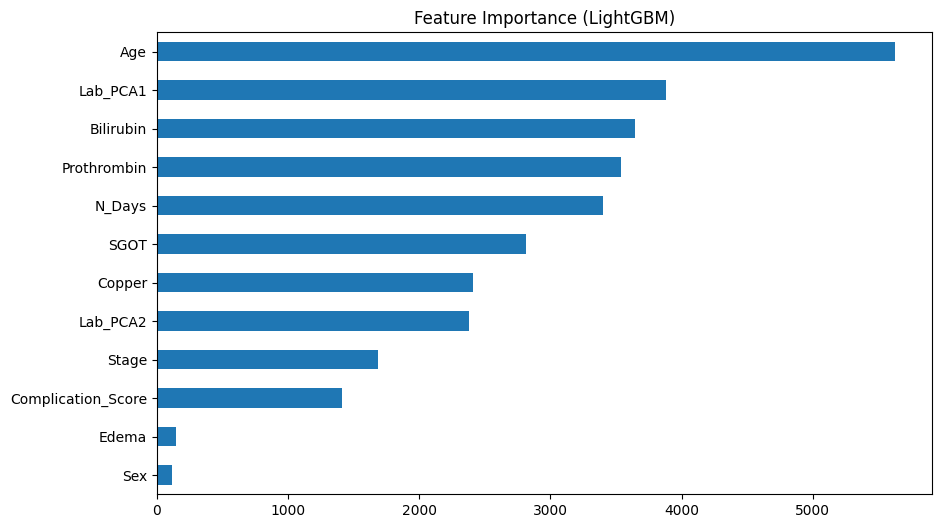

In [ ]:
print("\n--- Model Comparison ---")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

if best_model_name in ["RandomForest", "GradientBoosting", "XGBoost", "LightGBM"]:
    feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    feat_importances.sort_values().plot(kind='barh', figsize=(10,6))
    plt.title(f'Feature Importance ({best_model_name})')
    plt.show()

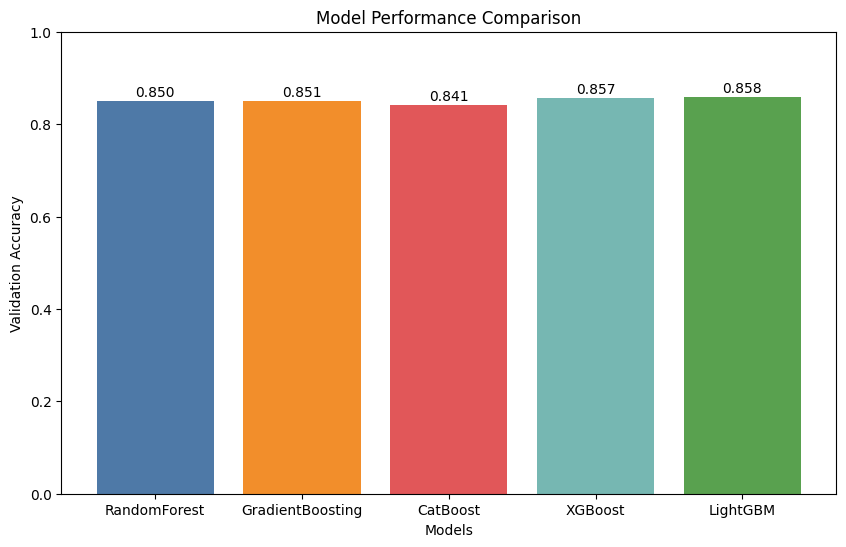

In [ ]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10,6))

# Use a nice colormap
#colors = plt.cm.Set2(range(len(model_names)))
colors = ["#4e79a7", "#f28e2b", "#e15759",
          "#76b7b2", "#59a14f", "#edc949",
          "#af7aa1", "#ff9da7"]


plt.bar(model_names, accuracies, color=colors)

plt.ylabel("Validation Accuracy")
plt.xlabel("Models")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="", alpha=0.6)

# Accuracy labels
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center')

plt.show()


# Submission

Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.459815
[100]	valid_0's multi_logloss: 0.403058
[150]	valid_0's multi_logloss: 0.387381
[200]	valid_0's multi_logloss: 0.381864
[250]	valid_0's multi_logloss: 0.379559
[300]	valid_0's multi_logloss: 0.378217
[350]	valid_0's multi_logloss: 0.377426
Early stopping, best iteration is:
[345]	valid_0's multi_logloss: 0.377337
0.8583333333333333
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2047
           1       0.41      0.28      0.33        69
           2       0.80      0.76      0.78       884

    accuracy                           0.86      3000
   macro avg       0.70      0.65      0.67      3000
weighted avg       0.85      0.86      0.86      3000



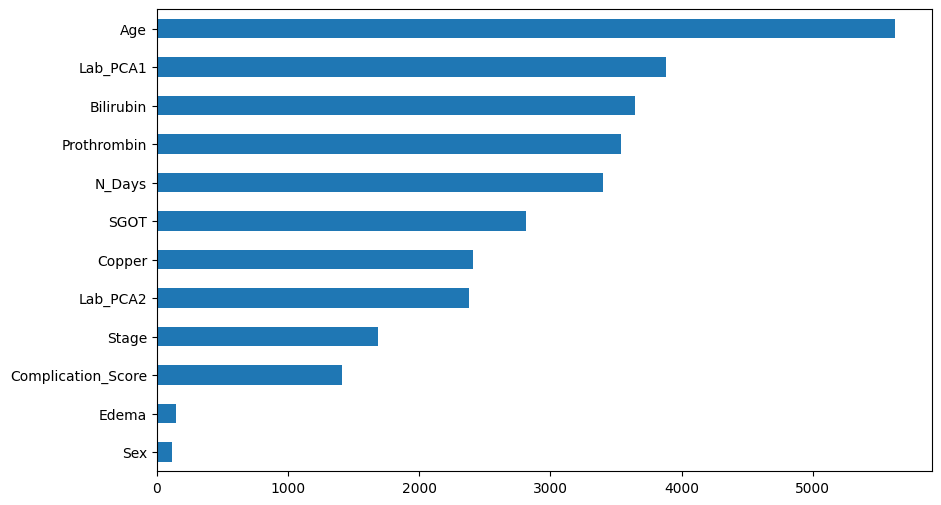

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle

X = train_df.drop(columns=['Status'])
y = train_df['Status']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(y.unique()),
    learning_rate=0.05,
    n_estimators=500,
    num_leaves=31,
    max_depth=-1,
    class_weight='balanced',
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

lgb_model.fit(
    X_res, y_res,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

y_pred = lgb_model.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

feat_importances = pd.Series(lgb_model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.show()

test_ids = test['id']

if 'id' in test_df.columns:
    X_test_final = test_df.drop(columns=['id'])
else:
    X_test_final = test_df.copy()

probs = lgb_model.predict_proba(X_test_final)
probs = probs.round(6)

with open('target_encoder.pkl', 'rb') as f:
    target_encoder = pickle.load(f)

class_names = target_encoder.classes_

submission_df = pd.DataFrame(probs, columns=[f"Status_{c}" for c in class_names])
submission_df.insert(0, 'id', test_ids.values)
submission_df.to_csv('submission.csv', index=False)


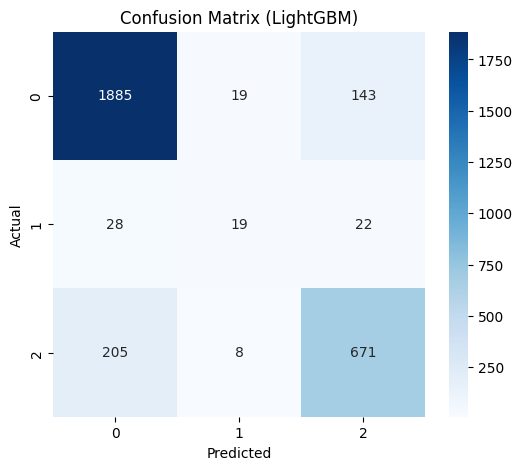

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (LightGBM)")
plt.show()


In [ ]:
y_pred = lgb_model.predict(X_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


0.8583333333333333
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2047
           1       0.41      0.28      0.33        69
           2       0.80      0.76      0.78       884

    accuracy                           0.86      3000
   macro avg       0.70      0.65      0.67      3000
weighted avg       0.85      0.86      0.86      3000



In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


classes = sorted(y.unique())
y_val_bin = label_binarize(y_val, classes=classes)


y_proba = lgb_model.predict_proba(X_val)


fig = go.Figure()

colors = px.colors.qualitative.Set2


for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)

    fig.add_trace(go.Scatter(
        x=fpr,
        y=tpr,
        mode='lines',
        name=f"Class {cls} (AUC={roc_auc:.3f})",
        line=dict(color=colors[i % len(colors)], width=3),
        hovertemplate=f"<b>Class: {cls}</b><br>FPR: %{{x}}<br>TPR: %{{y}}<extra></extra>"
    ))


fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name="Baseline (AUC=0.5)",
    line=dict(color="gray", width=2, dash='dash')
))


fig.update_layout(
    title="<b>ROC Curve</b>",
    title_x=0.5,
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(size=14),
    legend=dict(
        title="Classes",
        borderwidth=1,
        bgcolor="rgba(240,240,240,0.6)"
    ),
    hovermode="x unified"
)

fig.update_xaxes(showgrid=True, gridwidth=0.4, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=0.4, gridcolor='lightgray')

fig.show()


In [ ]:
import plotly.express as px
import pandas as pd


feat_importances = pd.Series(lgb_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)


feat_df = feat_importances.reset_index()
feat_df.columns = ['Feature', 'Importance']


fig = px.bar(
    feat_df,
    x='Importance',
    y='Feature',
    orientation='h',
    color='Importance',
    color_continuous_scale='Viridis',
    title='Feature Importance',
    text='Importance'
)

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title='Importance',
    yaxis_title='Feature',
    coloraxis_showscale=True,
    margin=dict(l=120, r=40, t=60, b=40)
)

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.show()


In [ ]:
from sklearn.calibration import calibration_curve
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import label_binarize


classes = sorted(y.unique())
y_val_bin = label_binarize(y_val, classes=classes)
y_proba = lgb_model.predict_proba(X_val)

fig = go.Figure()
colors = px.colors.qualitative.Set2


for i, cls in enumerate(classes):
    prob_true, prob_pred = calibration_curve(y_val_bin[:, i], y_proba[:, i], n_bins=10, strategy='uniform')

    fig.add_trace(go.Scatter(
        x=prob_pred,
        y=prob_true,
        mode='lines+markers',
        name=f"Class {cls}",
        line=dict(color=colors[i % len(colors)], width=3),
        marker=dict(size=8),
        hovertemplate=f"<b>Class {cls}</b><br>Predicted: %{{x:.2f}}<br>True: %{{y:.2f}}<extra></extra>"
    ))


fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Perfectly calibrated',
    line=dict(color='gray', width=2, dash='dash')
))


fig.update_layout(
    title="<b>Calibration Plot</b>",
    xaxis_title="Mean Predicted Probability",
    yaxis_title="Fraction of Positives",
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend=dict(title='Classes', borderwidth=1, bgcolor='rgba(240,240,240,0.6)'),
    hovermode="closest"
)

fig.update_xaxes(showgrid=True, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridcolor='lightgray')

fig.show()


In [ ]:
import plotly.express as px
import pandas as pd


y_proba = lgb_model.predict_proba(X_val)


prob_df = pd.DataFrame(y_proba, columns=[f"Class_{cls}" for cls in sorted(y.unique())])
prob_df['True_Class'] = y_val.values


prob_melt = prob_df.melt(id_vars='True_Class', var_name='Predicted_Class', value_name='Probability')


fig = px.violin(
    prob_melt,
    x='Predicted_Class',
    y='Probability',
    color='True_Class',
    box=True,  # show quartiles
    points='all',  # show all individual points
    hover_data=['Probability'],
    title="Class Probability Distribution",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    xaxis_title="Predicted Class",
    yaxis_title="Predicted Probability",
    legend_title="True Class",
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()
